# Google Drive

This first code block attaches your google drive and makes a folder structure. You only need to run this when a new VM is assigned to you. To get your code as a single python file go through the following menus File->'Download .py'.

This also downloads the 2 files that contain the dataset and the checkpoint:


https://drive.google.com/open?id=1ABUtpgdWMnMG6S6wLgqxXnAQ-8Fyq5F0

https://drive.google.com/open?id=1ilx871Zws-rS1Ek_ZAC-imD50A8bTQ80

In [0]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
from google.colab import drive

# Mount google drive
DRIVE_MOUNT='/content/gdrive'
drive.mount(DRIVE_MOUNT)


# create folder to write data to
CIS680_FOLDER=os.path.join(DRIVE_MOUNT, 'My Drive', 'CIS680_2019')
HOMEWORK_FOLDER=os.path.join(CIS680_FOLDER, 'HW4')
os.makedirs(HOMEWORK_FOLDER, exist_ok=True)

# bootstrap environment into place
from google.colab import auth
auth.authenticate_user()

from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

import io
import os
from googleapiclient.http import MediaIoBaseDownload

def download_file(fn, file_id):
    request = drive_service.files().get_media(fileId=file_id)
    downloaded = io.BytesIO()
    downloader = MediaIoBaseDownload(downloaded, request)
    done = False
    while done is False:
        # _ is a placeholder for a progress object that we ignore.
        # (Our file is small, so we skip reporting progress.)
        _, done = downloader.next_chunk()
    
    downloaded.seek(0)

    folder = fn.split('/')
    if len(folder) > 1:
        os.makedirs(folder[0], exist_ok=True)

    with open(fn, 'wb') as f:
        f.write(downloaded.read())

id_to_fn = {
'1ABUtpgdWMnMG6S6wLgqxXnAQ-8Fyq5F0': 'test.npz',
'1ilx871Zws-rS1Ek_ZAC-imD50A8bTQ80': 'train.npz',
}

# download all files into the vm
for fid, fn in id_to_fn.items():
    print("Downloading %s from %s" % (fn, fid))
    download_file(fn, fid)

Mounted at /content/gdrive


In [0]:
import torch
import torchvision as thv
import numpy as np
from pdb import set_trace as debug
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook
import time
from tqdm import tnrange
from skimage.transform import resize
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn.functional as F
import torch.nn as nn
import random
import torch.optim as optim
import torchvision.utils as vutils
import matplotlib.animation as animation
from IPython.display import HTML
import cv2

#DCGANS

In [0]:
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)

transform_ = transforms.Compose(
    [transforms.Resize(64),transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])



In [0]:
trainset_ = thv.datasets.STL10('./ ', split = 'train', download = True, transform=transform_)


Files already downloaded and verified


In [0]:
trainloader_ = torch.utils.data.DataLoader(trainset_, batch_size=32,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)

In [0]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

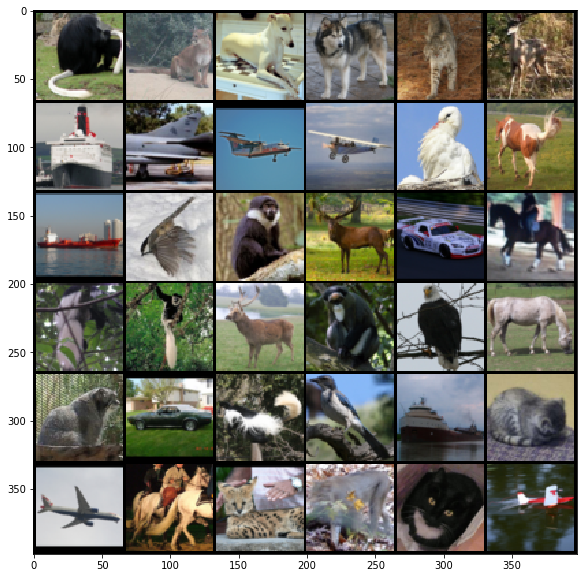

In [0]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize = (10,20))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader_)
images, labels = dataiter.next()
plt.figure(figsize=(20, 10))
plt.imshow(np.transpose(thv.utils.make_grid(images[:36], nrow=6, normalize=True), (1,2,0)))

In [0]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [0]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.tconv1 = nn.ConvTranspose2d(100, 1024,
            kernel_size=4, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(1024)

        self.tconv2 = nn.ConvTranspose2d(1024, 512,
            4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(512)

        self.tconv3 = nn.ConvTranspose2d(512,256,
            4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(256)

        self.tconv4 = nn.ConvTranspose2d(256, 128,
            4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(128)

        self.tconv5 = nn.ConvTranspose2d(128,3,
            4, 2, 1, bias=False)

    def forward(self, x):
        x = F.relu(self.bn1(self.tconv1(x)))
        x = F.relu(self.bn2(self.tconv2(x)))
        x = F.relu(self.bn3(self.tconv3(x)))
        x = F.relu(self.bn4(self.tconv4(x)))

        x = torch.tanh(self.tconv5(x))

        return x

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3,64,
            4, 2, 1, bias=False)

        self.conv2 = nn.Conv2d(64,128,
            4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(128,256,
            4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(256)

        self.conv4 = nn.Conv2d(256,512,
            4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(512)

        self.conv5 = nn.Conv2d(512, 1, 4, 1, 0, bias=False)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2, True)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.2, True)
        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.2, True)
        x = F.leaky_relu(self.bn4(self.conv4(x)), 0.2, True)

        x = self.conv5(x)

        return x


In [0]:
Discriminator_net = Discriminator().to(device)
Discriminator_net.apply(weights_init)


criterion = nn.BCEWithLogitsLoss()
noise_ = torch.randn(36, 100, 1, 1, device=device)

real_label = 1
fake_label = 0

Generator_net = Generator().to(device)
Generator_net.apply(weights_init)

In [0]:
netD = Discriminator().to(device)
netD.apply(weights_init)


criterion = nn.BCEWithLogitsLoss()
noise_ = torch.randn(36, 100, 1, 1, device=device)

real_label = 1
fake_label = 0

netG = Generator().to(device)
netG.apply(weights_init)

In [0]:
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
netD.train()
netG.train()
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(trainloader_, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(trainloader_),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        # if ((epoch == num_epochs-1) and (i == len(trainloader_)-1)):
        #     with torch.no_grad():
        #         fake = netG(fixed_noise).detach().cpu()
        #     img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        # iters += 1

In [0]:
def mount_drive():
  import os
  from google.colab import drive

  # Mount google drive
  DRIVE_MOUNT='/content/gdrive'
  drive.mount(DRIVE_MOUNT)


  # create folder to write data to
  CIS680_FOLDER=os.path.join(DRIVE_MOUNT, 'My Drive', 'CIS680_2019')
  HOMEWORK_FOLDER=os.path.join(CIS680_FOLDER, 'HW4')
  os.makedirs(HOMEWORK_FOLDER, exist_ok=True)

In [0]:
G_losses = []
D_losses = []
# Optimizer for the discriminator.
optimizerD = optim.Adam(Discriminator_net.parameters(), lr=2e-4, betas=(0.5, 0.999))
# Optimizer for the generator.
optimizerG = optim.Adam(Generator_net.parameters(), lr=2e-4, betas=(0.5, 0.999))
for i in tnrange(50):
  loss_g  = 0
  loss_d = 0
  for data, label in tqdm_notebook(trainloader_):
    data = data.to(device)
    Discriminator_net.zero_grad()
    real_label = torch.ones(data.shape[0], device = device).float()
    fake_label = torch.zeros(data.shape[0], device = device).float()

    
    disc_real = Discriminator_net(data)

    real_loss = criterion(disc_real.view(-1), real_label)
    real_loss.backward()

    

    noise = torch.randn([data.shape[0], 100, 1, 1], device = device)
    fake_image = Generator_net(noise)

    disc_fake = Discriminator_net(fake_image.detach())

    fake_loss = criterion(disc_fake.view(-1), fake_label)
    fake_loss.backward()

    disc_loss = real_loss + fake_loss
    loss_d += disc_loss.item()

    # disc_loss.backward()
    optimizerD.step()

    ## Train Generator
    Generator_net.zero_grad()

    gen_real = Discriminator_net(fake_image)

    gen_loss = criterion(gen_real.view(-1), real_label)
    loss_g += gen_loss.item()

    gen_loss.backward()
    optimizerG.step()

  # torch.save(Generator_net, '../content/gdrive/My Drive/CIS680_2019/HW4/Generator.pt')
  # torch.save(Discriminator_net, '../content/gdrive/My Drive/CIS680_2019/HW4/Discriminator.pt')

  print(f'Gen Loss {loss_g / len(trainloader_)} \n Disc Loss {loss_d / len(trainloader_)}')
  G_losses.append(loss_g / len(trainloader_))
  D_losses.append(loss_d / len(trainloader_))

  # if (i % 5 == 0):
  #       with torch.no_grad():
  #           netG_reload = torch.load('../content/gdrive/My Drive/CIS680_2019/HW4/Generator.pt')
  #           netG_reload.eval()
  #           fake = netG_reload(noise_).detach().cpu()
  #       imshow(thv.utils.make_grid(fake, nrow=6), )


    

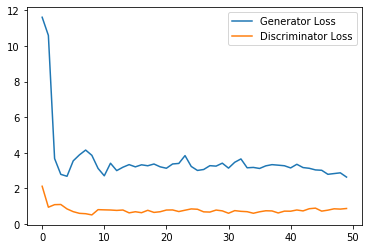

In [0]:
plt.plot(G_losses, label = 'Generator Loss')
plt.plot(D_losses, label = 'Discriminator Loss')

plt.legend()
plt.show()

In [0]:

noise_ = torch.randn(36, 100, 1, 1, device=device)
netG_reload = torch.load('../content/gdrive/My Drive/CIS680_2019/HW4/Generator.pt')
netG_reload.eval()
netG.eval()
with torch.no_grad():
    fake = netG_reload(noise_).detach().cpu()
    plt.figure(figsize=(20, 10))
    plt.imshow(np.transpose(thv.utils.make_grid(fake, nrow=6, normalize = True), (1,2,0)))


# SRGAN

In [0]:
def unzip_data(my_data):
  list_files = my_data.files
  if len(list_files):
    return my_data[list_files[0]]
  else:
    print('data is packed in multiple lists, change your logic')

In [0]:
unzipTrain = unzip_data(np.load('../content/train.npz', encoding="latin1", allow_pickle=True))

unzipTest = unzip_data(np.load('../content/test.npz', encoding="latin1", allow_pickle=True))

In [0]:
def low_res(image):
  img = image.astype(np.uint8)
  x14 = cv2.resize(img, dsize=(14, 14))
  x64 = cv2.resize(x14, dsize = (64, 64))
  return x64.astype(np.float64)


class SRDataset(Dataset):
    def __init__(self, images, transform):
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]

        low_res_image = low_res(image.copy())
        low_res_image = torch.from_numpy(np.transpose(low_res_image, (2,0,1))/255.0)
        image_lr = self.transform(low_res_image)
        image = torch.from_numpy(np.transpose(image, (2,0,1))/255.0)
        image_hr = self.transform(image)

        return image_lr, image_hr

In [0]:
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)

transform_SR = transforms.Compose([transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


In [0]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

In [0]:
datasetSR = SRDataset(images=unzipTrain,transform=transform_SR)


dataset_testSR = SRDataset(images=unzipTest, transform=transform_SR)

In [0]:
trainloader_SR = torch.utils.data.DataLoader(datasetSR, batch_size=32,
                                          shuffle=True, num_workers=2)

testloader_SR = torch.utils.data.DataLoader(dataset_testSR, batch_size=32,
                                         shuffle=False, num_workers=2)

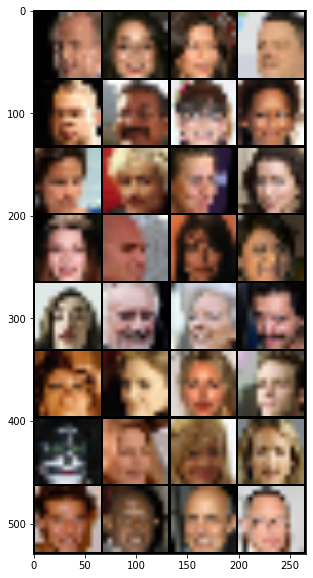

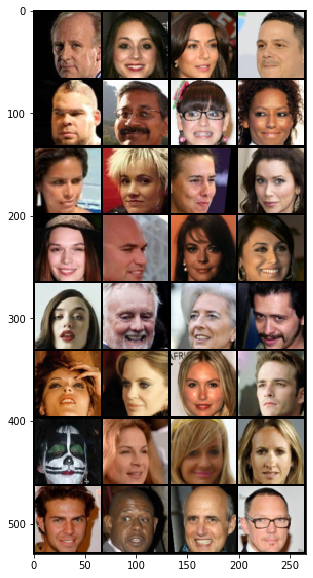

In [0]:
dataiter = iter(trainloader_SR)
images_lr, images_hr = dataiter.next()
plt.figure(figsize=(20, 10))

plt.imshow(np.transpose(thv.utils.make_grid(images_lr * 0.5 + 0.5, nrow=4), (1,2,0)))
plt.show()
plt.figure(figsize=(20, 10))
plt.imshow(np.transpose(thv.utils.make_grid(images_hr*0.5 + 0.5, nrow=4), (1,2,0)))
plt.show()

In [0]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)




class GeneratorSR(nn.Module):
    def __init__(self):
        super().__init__()
        ## Encoder
        self.conv1 = nn.Conv2d(3,32,
            4, 2, 1, bias=False)
        self.ebn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32,64,
            4, 2, 1, bias=False)
        self.ebn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64,128,
            4, 2, 1, bias=False)
        self.ebn3 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128,256,
            4, 2, 1, bias=False)
        self.ebn4 = nn.BatchNorm2d(256)

        self.conv5 = nn.Conv2d(256, 512, 4, 2, 1, bias=False)
        self.ebn5 = nn.BatchNorm2d(512)


        ## Decoder
        self.tconv1 = nn.ConvTranspose2d(512, 256,
            kernel_size=4, stride=2, padding=1, bias=False)
        self.dbn1 = nn.BatchNorm2d(256)

        self.tconv2 = nn.ConvTranspose2d(256 + 256, 128,
            4, 2, 1, bias=False)
        self.dbn2 = nn.BatchNorm2d(128)

        self.tconv3 = nn.ConvTranspose2d(128+ 128,64,
            4, 2, 1, bias=False)
        self.dbn3 = nn.BatchNorm2d(64)

        self.tconv4 = nn.ConvTranspose2d(64 + 64, 32,
            4, 2, 1, bias=False)
        self.dbn4 = nn.BatchNorm2d(32)

        self.tconv5 = nn.ConvTranspose2d(32 + 32,16,
            4, 2, 1, bias=False)
        self.dbn5 = nn.BatchNorm2d(16)
        self.tconv6 = nn.ConvTranspose2d(16+3,3,
            3, 1, 1)

    def forward(self, x):

        ## Encoder
        xe1 = self.conv1(x)
        xe1_bn = F.leaky_relu(self.ebn1(xe1), 0.2, inplace=True)
        xe2 = self.conv2(xe1_bn)
        xe2_bn = F.leaky_relu(self.ebn2(xe2), 0.2, inplace=True)
        xe3 = self.conv3(xe2_bn)
        xe3_bn = F.leaky_relu(self.ebn3(xe3), 0.2, inplace=True)
        xe4 = self.conv4(xe3_bn)
        xe4_bn = F.leaky_relu(self.ebn4(xe4), 0.2, inplace=True)
        xe5 = self.conv5(xe4_bn)
        # debug()
        xe5_bn = F.leaky_relu(self.ebn5(xe5), 0.2, inplace=True)

        ## Decoder
        xd1 = F.leaky_relu(self.dbn1(self.tconv1(xe5_bn)), 0.2, inplace=True)
        # debug()
        xd2 = F.leaky_relu(self.dbn2(self.tconv2(torch.cat([xd1, xe4], dim = 1))), 0.2, inplace=True)
        xd3 = F.leaky_relu(self.dbn3(self.tconv3(torch.cat([xd2, xe3], dim = 1))), 0.2, inplace=True)
        xd4 = F.leaky_relu(self.dbn4(self.tconv4(torch.cat([xd3, xe2], dim = 1))), 0.2, inplace=True)
        xd5 = F.leaky_relu(self.dbn5(self.tconv5(torch.cat([xd4, xe1], dim = 1))), 0.2, inplace=True)
        xd6 = self.tconv6(torch.cat([xd5, x], dim = 1))

        return torch.tanh(xd6)

class DiscriminatorSR(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3,32,
            4, 2, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32,64,
            4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64,128,
            4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128,256,
            4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(256)

        self.conv5 = nn.Conv2d(256,512,
            4, 2, 1, bias=False)
        self.bn5 = nn.BatchNorm2d(512)

        self.conv6 = nn.Conv2d(512, 1, 3, 2, 1)

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)), 0.2, True)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.2, True)
        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.2, True)
        x = F.leaky_relu(self.bn4(self.conv4(x)), 0.2, True)
        x = F.leaky_relu(self.bn5(self.conv5(x)), 0.2, True)

        x = self.conv6(x)

        return x


In [0]:
netD = DiscriminatorSR().to(device)
netD.apply(weights_init)


criterion = nn.BCEWithLogitsLoss()
criterionMSE = nn.MSELoss()
noise_ = torch.randn(36, 100, 1, 1, device=device)


netG = GeneratorSR().to(device)
netG.apply(weights_init)
netD.train().float()
netG.train().float()


real_label = 1
fake_label = 0

In [0]:

optimizerD = optim.Adam(netD.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=2e-4, betas=(0.5, 0.999))
img_list = []
G_losses = []
D_losses = []
Rec_losses = []
lsgan = False

dataiter = iter(trainloader_SR)
images_lr_plot, images_hr_plot = dataiter.next()
plt.figure(figsize=(20, 10))

plt.imshow(np.transpose(thv.utils.make_grid(images_lr_plot * 0.5 + 0.5, nrow=4), (1,2,0)))
plt.show()
plt.figure(figsize=(20, 10))
plt.imshow(np.transpose(thv.utils.make_grid(images_hr_plot*0.5 + 0.5, nrow=4), (1,2,0)))
plt.show()

for epoch in tnrange(100):
    loss_d = 0
    loss_g = 0
    loss_recon = 0
    for i, (data_lr,data_hr) in enumerate(tqdm_notebook(trainloader_SR), 0):
        
        # Transfer data tensor to GPU/CPU (device)
        real_data = data_hr.to(device).float()
        # Get batch size. Can be different from params['nbsize'] for last batch in epoch.
        b_size = real_data.size(0)
        
        # Make accumalated gradients of the discriminator zero.
        netD.zero_grad()
        # Create labels for the real data. (label=1)
        label = torch.full((b_size, ), real_label, device=device)
        output = netD(real_data).view(-1)
        if lsgan:
          errD_real = 0.5 * criterionMSE(output, label)
        else:
          errD_real = criterion(output, label)
        # Calculate gradients for backpropagation.
        errD_real.backward()
        D_x = output.mean().item()
        
        # Sample random data from a unit normal distribution.
        fake = data_lr.to(device).float()
        # Generate fake data (images).
        fake_data = netG(fake)
        # Create labels for fake data. (label=0)
        label.fill_(fake_label)
        # Calculate the output of the discriminator of the fake data.
        # As no gradients w.r.t. the generator parameters are to be
        # calculated, detach() is used. Hence, only gradients w.r.t. the
        # discriminator parameters will be calculated.
        # This is done because the loss functions for the discriminator
        # and the generator are slightly different.
        output = netD(fake_data.detach()).view(-1)
        if lsgan:
          errD_fake = 0.5 * criterionMSE(output, label)
        else:
          errD_fake = criterion(output, label)
        # Calculate gradients for backpropagation.
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        # Net discriminator loss.
        errD = errD_real + errD_fake
        loss_d +=  errD.item()
        # Update discriminator parameters.
        optimizerD.step()
        
        # Make accumalted gradients of the generator zero.
        netG.zero_grad()
        # We want the fake data to be classified as real. Hence
        # real_label are used. (label=1)
        label.fill_(real_label)
        # No detach() is used here as we want to calculate the gradients w.r.t.
        # the generator this time.
        output = netD(fake_data).view(-1)

        if lsgan:
          errG = 0.5 * criterionMSE(output, label)
        else:

          errG = criterion(output, label)
          

        recon_loss = criterionMSE(fake_data, real_data)
        loss_g+= errG.item()
        loss_recon += recon_loss.item()

        # Gradients for backpropagation are calculated.
        # Gradients w.r.t. both the generator and the discriminator
        # parameters are calculated, however, the generator's optimizer
        # will only update the parameters of the generator. The discriminator
        # gradients will be set to zero in the next iteration by netD.zero_grad()
        errG_loss = recon_loss + errG

        errG_loss.backward()

        D_G_z2 = output.mean().item()
        # Update generator parameters.
        optimizerG.step()

    torch.save(netG, '../content/gdrive/My Drive/CIS680_2019/HW4/GeneratorSR.pt')
    torch.save(netD, '../content/gdrive/My Drive/CIS680_2019/HW4/DiscriminatorSR.pt')

    print(f'Gen Loss {loss_g / len(trainloader_SR)} \n Disc Loss {loss_d / len(trainloader_SR)} \n recon loss {loss_recon / len(trainloader_SR)}')

    # Save Losses for plotting later
    G_losses.append(loss_g / len(trainloader_SR))
    D_losses.append(loss_d / len(trainloader_SR))
    Rec_losses.append(loss_recon / len(trainloader_SR))

    # Check how the generator is doing by saving G's output on fixed_noise
    if (epoch % 5 == 0) or epoch == 99:
        netG_reload = torch.load('../content/gdrive/My Drive/CIS680_2019/HW4/GeneratorSR.pt').to(device)
        netG_reload.eval()
        with torch.no_grad():
            # dataiter = iter(trainloader_SR)
            images_lr_test, images_hr_test = images_lr_plot.clone(), images_hr_plot.clone()
            plt.figure(figsize=(20, 10))
            fake_test = netG_reload(images_lr_test.to(device).float()).detach().cpu()
            plt.imshow(np.transpose(thv.utils.make_grid(fake_test*0.5 + 0.5, nrow=4), (1,2,0)))
            plt.show()
            plt.figure(figsize=(20, 10))
            plt.imshow(np.transpose(thv.utils.make_grid(images_hr_test*0.5 + 0.5, nrow=4), (1,2,0)))
            plt.show()


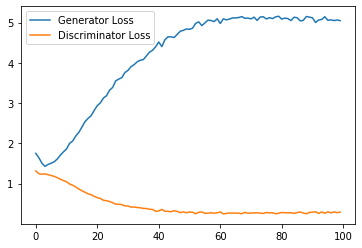

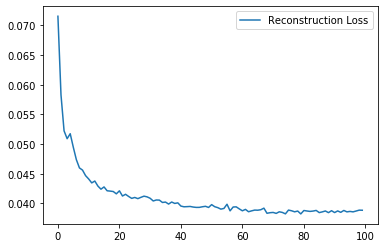

In [0]:
plt.plot(G_losses, label = 'Generator Loss')
plt.plot(D_losses, label = 'Discriminator Loss')


plt.legend()
plt.show()

plt.plot(Rec_losses, label = 'Reconstruction Loss')
plt.legend()
plt.show()

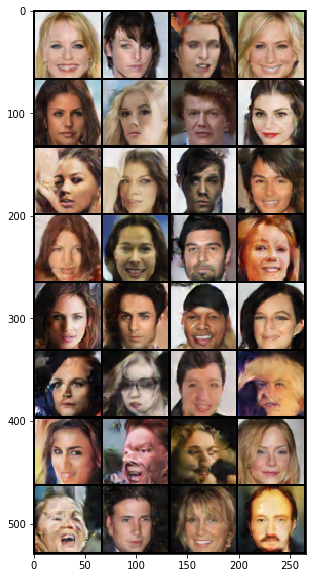

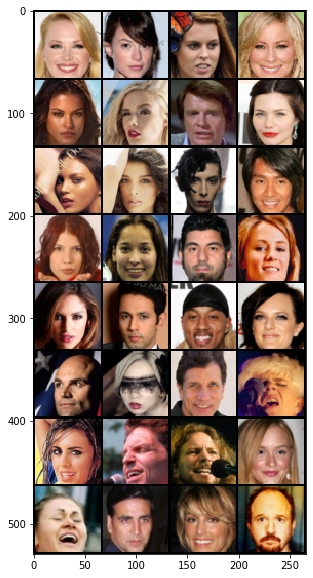

In [0]:
netG_reload = torch.load('../content/gdrive/My Drive/CIS680_2019/HW4/GeneratorSR.pt').to(device)
netG_reload.eval()
with torch.no_grad():
    dataiter = iter(testloader_SR)
    images_lr_test, images_hr_test = next(dataiter)
    plt.figure(figsize=(20, 10))
    fake_test = netG_reload(images_lr_test.to(device).float()).detach().cpu()
    plt.imshow(np.transpose(thv.utils.make_grid(fake_test*0.5 + 0.5, nrow=4), (1,2,0)))
    plt.show()
    plt.figure(figsize=(20, 10))
    plt.imshow(np.transpose(thv.utils.make_grid(images_hr_test*0.5 + 0.5, nrow=4), (1,2,0)))
    plt.show()